In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import pathlib
import sys

home = pathlib.Path().resolve().parent
path = str(pathlib.Path(home, r'Andrey'))
sys.path.insert(0, home)

from src.mixture_fit import gen_data, fits, sum_exp_curv, fit, sum_exp, loss_function, right_order
from src.data_loading import load_data
from src.optimal_number import optimal_params
from src.log_data_analysis import log_estimate, bounds
from src.errors import bootstrap_resudial, bootstrap_residual
from src.bootstrapping import bootstrap, final_guess

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

%matplotlib widget


## Стабильность.

Повторяемость получаемых результатов. Тестируется на наборе R2-5times + симуляции с различными погрешностями.

### Стабильность

In [3]:
def stability(fun: callable, mode='simulate', bs_num=100, comp_num=1, log=True, save_path=None, *args, **kwargs):
    if mode == 'simulate':
        if comp_num > 4:
            raise ValueError('Current state of method only supports simmulation for up to 4 components')
        D_coeff = np.array([0.306, 0.463, 0.694, 1.042])[:comp_num]
        w_coeff = 1 / comp_num

        parameters = np.zeros(2 * comp_num)
        parameters[1::2] = D_coeff
        parameters[::2] = w_coeff
        folder = pathlib.Path(path,'data', 'R2_5times')
        data_path = pathlib.Path(folder, f'DOSY-R2-1-4-DMSO-128points-1.txt')
        x, _ = load_data(data_path)
        y_model = sum_exp(parameters, x)

        res, res_std, guessed_count = [], [], []
        stacked_res_array = []
        sigma_range = np.geomspace(2e-3, 2e-1, 15)
        for calc_sigma in tqdm(sigma_range, total=len(sigma_range)):
            # print(f'Processing sigma = {sigma:.2E}')
            try:
                result, optim_res = bootstrap(fun, x, y_model, calc_sigma, bs_num, show_progress=False, *args, **kwargs)
                correct_guess = (optim_res[:, 0] == comp_num-1)
                if correct_guess.sum() == 0:
                    correct_mean = np.zeros(comp_num * 2)
                    correct_std = np.zeros(comp_num * 2)
                    stacked_res_array.append(np.zeros((bs_num, comp_num * 2))) 
                else:
                    stacked_res = np.vstack(optim_res[:, 1][correct_guess])
                    correct_mean = stacked_res.mean(0)
                    correct_std = stacked_res.std(0)
                    stacked_res_array.append(stacked_res)
            except ValueError:
                correct_guess = np.array([0])
                correct_mean = np.zeros(comp_num * 2)
                correct_std = np.zeros(comp_num * 2)
                stacked_res_array.append(np.zeros((bs_num, comp_num * 2))) 
            guessed_count.append(correct_guess.sum())
            res.append(correct_mean)
            res_std.append(correct_std)
        
        guessed_count = np.array(guessed_count)
        res = np.vstack(res)
        res_std = np.vstack(res_std)
        stacked_res_array = np.array(stacked_res_array)

        if log:
            plt.close('all')
            plt.figure(figsize=(14, 4))
            plt.subplot(1, 3, 1)
            plt.plot(sigma_range, guessed_count)
            plt.ylim(-bs_num*0.05, 1.05*bs_num)
            plt.title('Number of correct guesses')
            plt.xscale('log')
            for i in range(comp_num):
                plt.subplot(comp_num, 3, 2 + 3 * i)
                plt.xscale('log')
                plt.hlines(parameters[2 * i], sigma_range[0], sigma_range[-1])
                plt.errorbar(sigma_range, res[:, 2 * i], res_std[:, 2 * i], fmt='.', c='blue')
                plt.ylim(-0.1, 1.1)
                
                plt.subplot(comp_num, 3, 3 + 3 * i)
                plt.xscale('log')
                plt.hlines(parameters[2 * i + 1], sigma_range[0], sigma_range[-1])
                plt.errorbar(sigma_range, res[:, 2 * i+1], res_std[:, 2 * i+1], fmt='.', c='blue')
                plt.ylim(-0.1, 1.1)
                for idx in range(15):
                    points_num = len(stacked_res_array[idx])
                    plt.subplot(comp_num, 3, 2 + 3 * i)
                    plt.scatter([sigma_range[idx]] * points_num, stacked_res_array[idx][:, 2 * i], c='lightblue', alpha=0.5)

                    plt.subplot(comp_num, 3, 3 + 3 * i)
                    plt.scatter([sigma_range[idx]] * points_num, stacked_res_array[idx][:,2 * i + 1], c='lightblue', alpha=0.5)
            plt.subplot(comp_num, 3, 2)
            plt.title('w coefficients')
            plt.subplot(comp_num, 3, 3)
            plt.title('D coefficients')
            plt.tight_layout()
            if save_path is not None:
                plt.savefig(save_path, dpi=300)
            else:
                plt.show()
        
        return sigma_range, guessed_count, res, res_std

    elif mode == 'real':
        results = []
        y_arr = [] 
        for i in range(5):
            folder = pathlib.Path(path,'data', 'R2_5times')
            data_path = pathlib.Path(folder, f'DOSY-R2-1-4-DMSO-128points-{i + 1}.txt')
            x, y = load_data(data_path)
            y_arr.append(y)

            res = fun(x, y, *args, **kwargs)
            results.append(res)
        y_arr = np.vstack(y_arr)
        sigma = y_arr.std(0)
        sigma[0] = sigma[1]
        results = np.vstack(results)
        results_std = ((results - results.mean(0)) ** 2).mean(0) ** 0.5
        
        guesses = []
        correct_idx = []
        for i in range(5):
            guess = final_guess(x, y, sigma, results[i], results_std)
            guesses.append(guess)
            if guess[0] == 0:
                correct_idx.append(i)
            if log:
                print(f'Guessed number of components = {guess[0] + 1}, params = {guess[1]}')
        guesses = np.array(guesses)
        if log:
            print(f'Correctly guesses {len(correct_idx)}/5')
            stacked = np.vstack(guesses[correct_idx])
            stacked_mean = stacked[:, 1].mean(0)
            stacked_std = ((stacked[:, 1] - stacked_mean.reshape(-1, 1)) ** 2).mean() ** 0.5
            print(f'w = {stacked_mean[0]:.4f} ± {stacked_std[0]:.4f}')
            print(f'D = {stacked_mean[1]:.4f} ± {stacked_std[1]:.4f}')   
        return results, guesses
            
    else:
        raise ValueError('Mode must be "simulate" or "real"!')

In [4]:
# sigma_range, guessed_count, res, res_std = stability(fits, comp_num=3, bs_num=100, log=True, method='L-BFGS-B', reg=0.05)
# sigma_range, guessed_count, res, res_std = stability(fits_ls, comp_num=2, bs_num=100, log=True)
res_real, guess = stability(fits, mode='real', method='BFGS', boost=True)

Guessed number of components = 1, params = [0.99281697 1.11165954]
Guessed number of components = 1, params = [1.01858577 1.10719613]
Guessed number of components = 1, params = [0.99551101 1.10903355]
Guessed number of components = 2, params = [5.97862667e-04 1.33322852e-06 9.98049362e-01 1.12054471e+00]
Guessed number of components = 1, params = [0.99721114 1.13487439]
Correctly guesses 4/5
w = 1.0010 ± 0.0817
D = 1.1157 ± 0.0818


In [1]:
path_to_fig = r'D:\Programms\Jupyter\NPM\Andrey\figures\Comparison'
# stability(fits, comp_num=1, bs_num=100, log=True, save_path=path_to_fig+r'\comp_num=1_weighted=False_reg=0.png', method='BFGS', boost=True)
# stability(fits, comp_num=2, bs_num=100, log=True, save_path=path_to_fig+r'\comp_num=2_weighted=False_reg=0.png', method='BFGS', boost=True)

# stability(fits, comp_num=1, bs_num=100, log=True, save_path=path_to_fig+r'\comp_num=1_weighted=True_reg=0.png', method='BFGS', boost=True, sigma=0.018)
# stability(fits, comp_num=2, bs_num=100, log=True, save_path=path_to_fig+r'\comp_num=2_weighted=True_reg=0.png', method='BFGS', boost=True, sigma=0.018)

# stability(fits, comp_num=1, bs_num=100, log=True, save_path=path_to_fig+r'\comp_num=1_weighted=True_reg=0.05.png', method='BFGS', boost=True, sigma=0.018, reg=0.05)
# stability(fits, comp_num=2, bs_num=100, log=True, save_path=path_to_fig+r'\comp_num=2_weighted=True_reg=0.05.png', method='BFGS', boost=True, sigma=0.018, reg=0.05)

# stability(fits, comp_num=1, bs_num=100, log=True, save_path=path_to_fig+r'\comp_num=1_weighted=True_reg=0.25.png', method='BFGS', boost=True, sigma=0.018, reg=0.25)
# stability(fits, comp_num=2, bs_num=100, log=True, save_path=path_to_fig+r'\comp_num=2_weighted=True_reg=0.25.png', method='BFGS', boost=True, sigma=0.018, reg=0.25)

stability(fits, comp_num=1, bs_num=100, log=True, save_path=path_to_fig+r'\comp_num=1_weighted=True_reg=0.5.png', method='BFGS', boost=True, sigma=0.018, reg=0.5)
# stability(fits, comp_num=2, bs_num=100, log=True, save_path=path_to_fig+r'\comp_num=2_weighted=True_reg=0.5.png', method='BFGS', boost=True, sigma=0.018, reg=0.5)

stability(fits, comp_num=1, bs_num=100, log=True, save_path=path_to_fig+r'\comp_num=1_weighted=True_reg=1.0.png', method='BFGS', boost=True, sigma=0.018, reg=1)
stability(fits, comp_num=2, bs_num=100, log=True, save_path=path_to_fig+r'\comp_num=2_weighted=True_reg=1.0.png', method='BFGS', boost=True, sigma=0.018, reg=1)

NameError: name 'stability' is not defined

  0%|          | 0/15 [00:00<?, ?it/s]

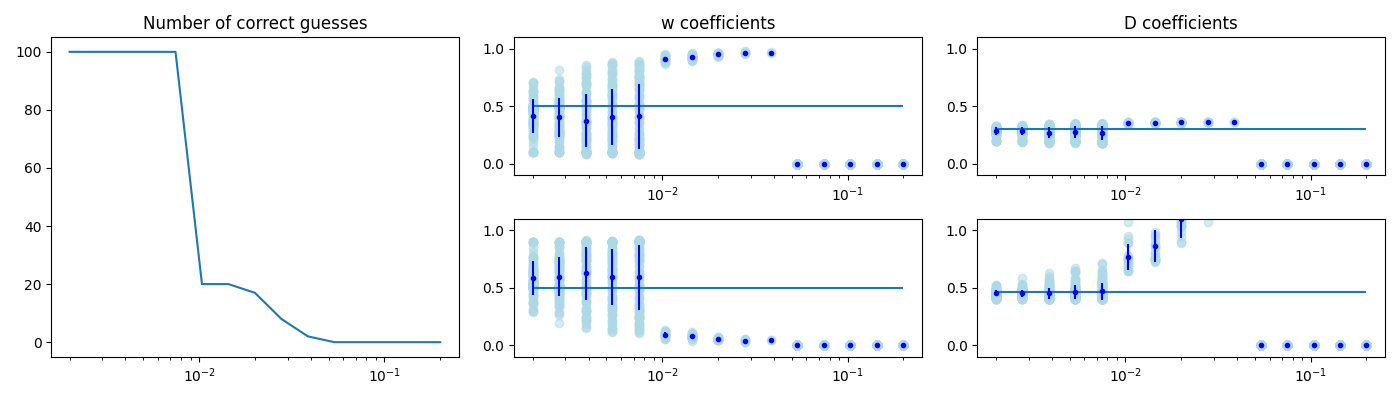

In [8]:
# sigma_range, guessed_count, res, res_std = stability(fits, comp_num=2, bs_num=100, log=True, method='L-BFGS-B')
sigma_range, guessed_count, res, res_std = stability(fits, comp_num=2, bs_num=100, log=True, method='L-BFGS-B', boost=True, sigma=0.018)

In [3]:
# folder = pathlib.Path(path,'data', 'R2_5times')
# data_path = pathlib.Path(folder, f'DOSY-R2-1-4-DMSO-128points-1.txt')
folder = pathlib.Path(path,'data', 'R2-R5')
data_path = pathlib.Path(folder, f'R2-R5-2-5.txt')
x, y = load_data(data_path)
# y_model = sum_exp([0.5, 0.304, 0.5, 0.504], x)
params = fits(x, y, method='BFGS', boost=True, sigma=0.018)

In [22]:
y_model = sum_exp(np.array([0.5, 0.7, 0.5, 0.5]), x)

In [26]:
res, res_opt = bootstrap(fits, x, y_model, 0.018, num=500, method='BFGS', boost=True, sigma=0.018)

  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
from src.errors import plot_parameters_space

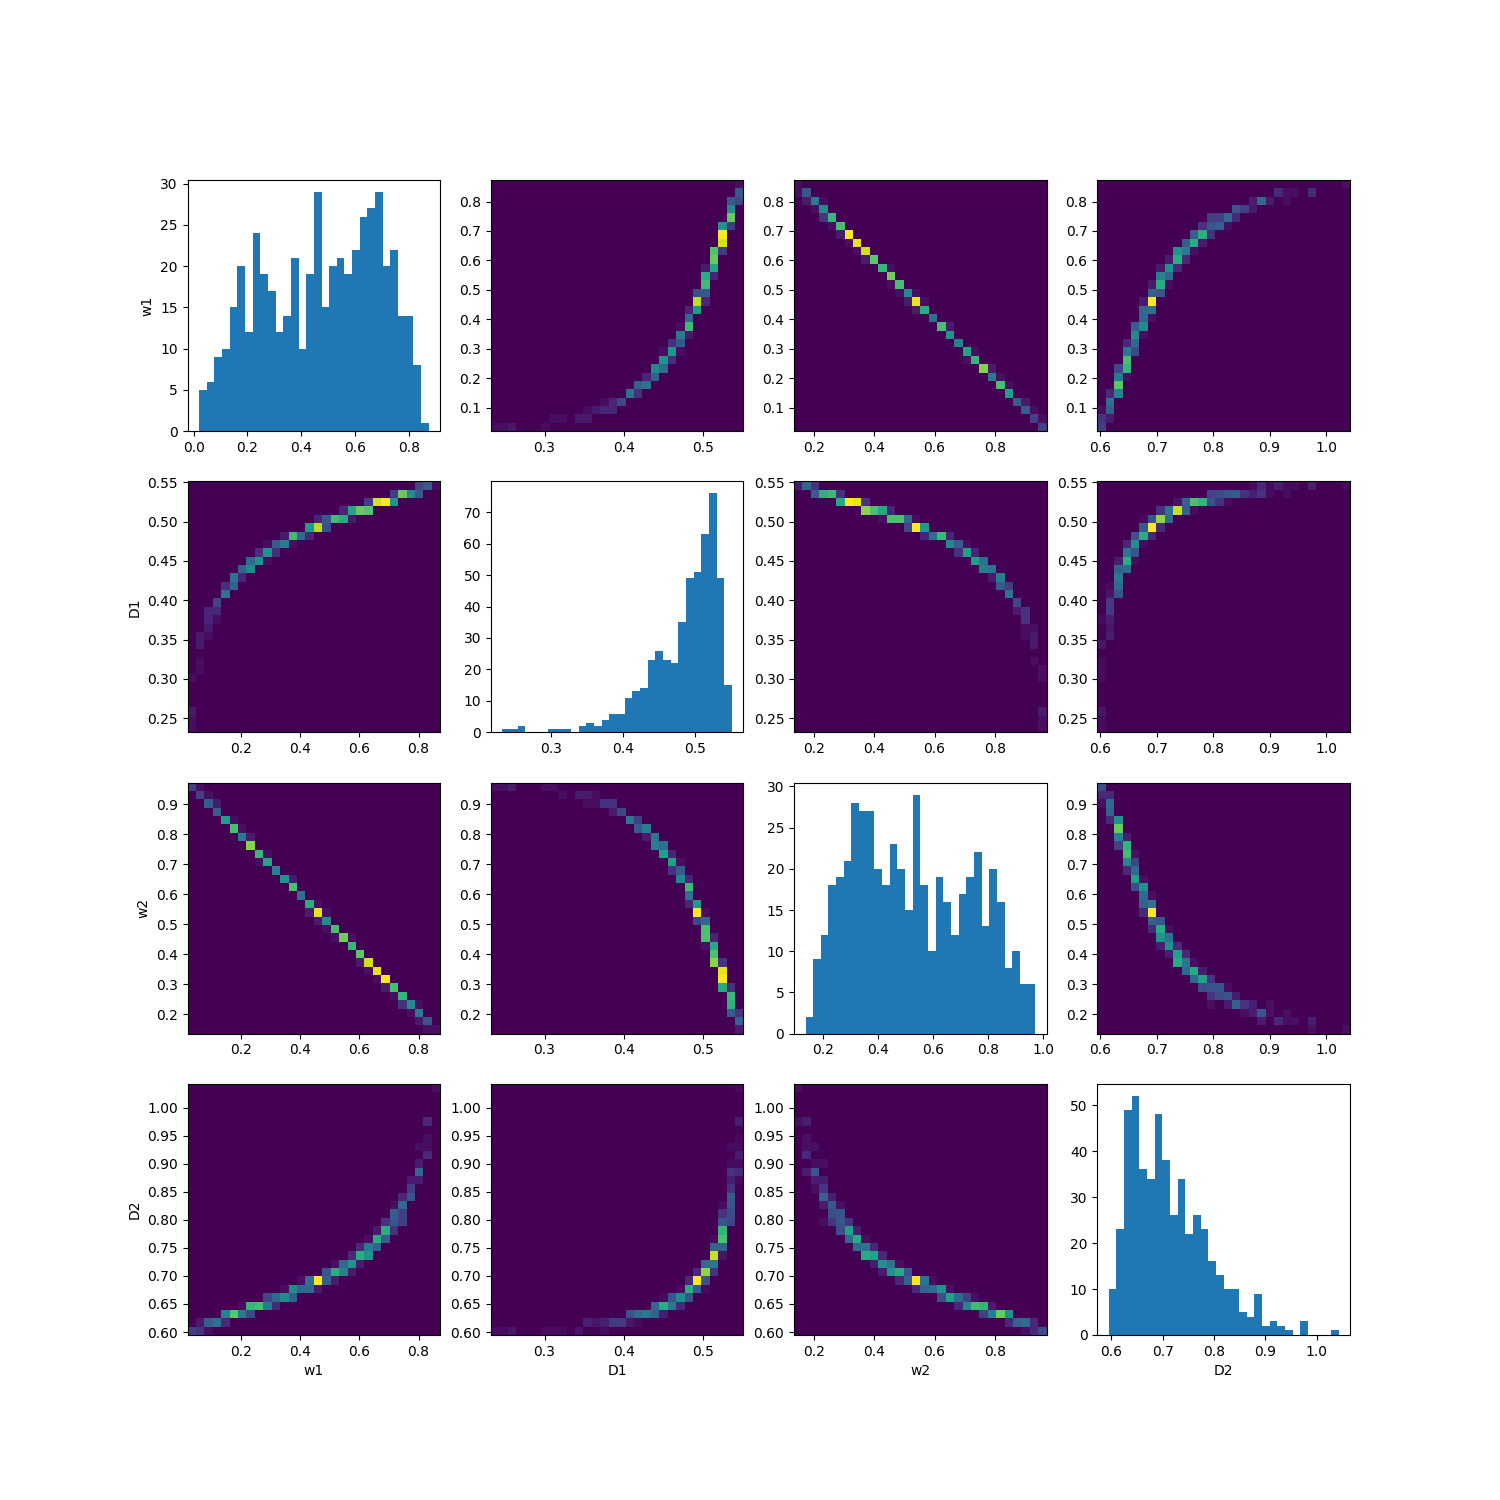

In [28]:
plot_parameters_space(np.vstack(res_opt[:, 1]), bins=30)

In [15]:
np.vstack(res_opt[:, 1])

array([[0.89846287, 0.49636916, 0.12307237, 2.56829878],
       [0.901338  , 0.49726417, 0.10886639, 2.5309923 ],
       [0.89855348, 0.49653538, 0.10944097, 2.31623001],
       [0.89664737, 0.49592349, 0.10263864, 2.06944517],
       [0.89623791, 0.49600439, 0.10372692, 2.16037863],
       [0.90086588, 0.49714969, 0.10607148, 2.28510693],
       [0.89998969, 0.49679256, 0.11216433, 2.51549818],
       [0.90045242, 0.49698963, 0.10449112, 2.48412923],
       [0.89528598, 0.49580667, 0.12386977, 2.25400646],
       [0.89793732, 0.49613973, 0.10955357, 2.33972897],
       [0.89839695, 0.49640137, 0.11405713, 2.38283844],
       [0.89315868, 0.49526053, 0.10556087, 1.92727842],
       [0.8986337 , 0.49647701, 0.12337442, 2.57432871],
       [0.89965126, 0.4966329 , 0.11380034, 2.41818542],
       [0.90361861, 0.49775918, 0.11530851, 2.66764865],
       [0.90104573, 0.49727824, 0.11111146, 2.5083532 ],
       [0.8996379 , 0.49662509, 0.1119319 , 2.71389078],
       [0.9041571 , 0.49781723,